In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings("ignore")

In [54]:
data= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data 601/Final Project/Crime_Data.csv")

In [55]:
data.head(3)

,X,Y,RowID,CCNumber,CrimeDateTime,CrimeCode,Description,Inside_Outside,Weapon,Post,...,Ethnicity,Location,Old_District,New_District,Neighborhood,Latitude,Longitude,GeoLocation,PremiseType,Total_Incidents
0,-76.610023,39.289875,1,23C00366,2023/03/02 02:17:00+00,6F,LARCENY,Inside,PERSONAL_WEAPONS,111.0,...,NaN,400 E BALTIMORE ST,CENTRAL,NaN,DOWNTOWN,39.289875,-76.610023,"(39.289875155299512,-76.610022671156329)",STREET,1
1,-76.610023,39.289875,2,23C00366,2023/03/02 02:17:00+00,6F,LARCENY,Inside,PERSONAL_WEAPONS,111.0,...,NaN,400 E BALTIMORE ST,CENTRAL,NaN,DOWNTOWN,39.289875,-76.610023,"(39.289875155299512,-76.610022671156329)",STREET,1
2,-76.609676,39.289694,3,23C06833,2023/03/02 00:13:00+00,4E,COMMON ASSAULT,Outside,PERSONAL_WEAPONS,111.0,...,NOT_HISPANIC_OR_LATINO,400 E BALTIMORE ST,CENTRAL,NaN,DOWNTOWN,39.289694,-76.609676,"(39.289693999999997,-76.609675999999993)",TAVERN/NIGHT CLUB,1


# DATA PREPROCESSING

### Filter the Necessary Data

In [56]:
#Filter the data for 2017-2022
data['Date'] = pd.to_datetime(data['CrimeDateTime'], errors='coerce')
data = data[(data['Date'].dt.year >=2017) & (data['Date'].dt.year <=2022)]

# Extracting year from date
data["Year"]= data["Date"].dt.year

# Filter for required columns
df= data[["CCNumber","Year","Description","Inside_Outside","Weapon","Gender","Age","Race","Neighborhood","Total_Incidents"]]

#Filter the data for the crimes- Murders, Shootings and Aggrevated Assaults
crimes=["HOMICIDE","SHOOTING","AGG. ASSAULT"]
df=df[df["Description"].isin(crimes)]

# df.dropna(inplace=True)
# print("shape of the data after droppping", df.shape)
df.head()

,CCNumber,Year,Description,Inside_Outside,Weapon,Gender,Age,Race,Neighborhood,Total_Incidents
14,19J07980,2019,AGG. ASSAULT,O,KNIFE,M,27.0,BLACK_OR_AFRICAN_AMERICAN,MCELDERRY PARK,1
15,19J08041,2019,AGG. ASSAULT,I,OTHER,M,46.0,BLACK_OR_AFRICAN_AMERICAN,EAST BALTIMORE MIDWAY,1
21,19J08241,2019,AGG. ASSAULT,I,OTHER,M,48.0,UNKNOWN,WESTPORT,1
689,18L08788,2018,AGG. ASSAULT,I,OTHER,F,33.0,BLACK_OR_AFRICAN_AMERICAN,FRANKFORD,1
693,18L08985,2018,AGG. ASSAULT,I,KNIFE,M,59.0,BLACK_OR_AFRICAN_AMERICAN,FRANKFORD,1


### Clean the data

In [57]:
#standardize gender
df['Gender'] = df['Gender'].replace({'Male': 'M', 'Female': 'F'})
df=df[df["Gender"].isin(["M","F"])]

#standardize inside_outside
df['Inside_Outside'] = df['Inside_Outside'].replace({'I': 'Inside', 'O': 'Outside'})

#remove outliers from Age
q1 = df['Age'].quantile(0.05)
q3 = df['Age'].quantile(0.95)
df= df[(df['Age'] >= q1) & (df['Age'] <= q3)]
#change datatype of age
df['Age'] = df['Age'].astype(int)

#filter the race column
df['Race'] = df['Race'].replace({'BLACK_OR_AFRICAN_AMERICAN':'BLACK'})
df=df[df["Race"].isin(["WHITE","BLACK"])]

#remove unknown from race and weapon
replace=['UNKNOWN']
df.replace(replace, np.nan, inplace=True)
df.dropna(inplace=True)

# Convert 'Neighborhood' column to uppercase
df['Neighborhood'] = df['Neighborhood'].str.upper()

# Set 'CCNumber' column as the index
df.set_index('CCNumber', inplace=True)

In [58]:
#checking the unique values for all columns
for col in df.columns:
  print("\n---------VALUE COUNTS FOR------------ ", col)
  print(df[col].value_counts())


---------VALUE COUNTS FOR------------  Year
2022    5633
2021    4880
2019    4347
2018    4016
2020    3898
2017    3824
Name: Year, dtype: int64

---------VALUE COUNTS FOR------------  Description
AGG. ASSAULT    20719
SHOOTING         4037
HOMICIDE         1842
Name: Description, dtype: int64

---------VALUE COUNTS FOR------------  Inside_Outside
Outside    16408
Inside     10190
Name: Inside_Outside, dtype: int64

---------VALUE COUNTS FOR------------  Weapon
FIREARM                     10464
OTHER                        5761
KNIFE                        2893
PERSONAL_WEAPONS             2042
HANDS                        1827
KNIFE_CUTTING_INSTRUMENT     1155
HANDGUN                      1141
BLUNT_OBJECT                  844
MOTOR_VEHICLE_VESSEL          204
AUTOMATIC_HANDGUN              60
ASPHYXIATION                   42
AUTOMATIC_FIREARM              34
OTHER_FIREARM                  34
FIRE_INCENDIARY_DEVICE         29
SHOTGUN                        27
RIFLE                

In [59]:
print(df.shape)
df.head(3)

(26598, 9)


,Year,Description,Inside_Outside,Weapon,Gender,Age,Race,Neighborhood,Total_Incidents
CCNumber,,,,,,,,,
19J07980,2019,AGG. ASSAULT,Outside,KNIFE,M,27,BLACK,MCELDERRY PARK,1
19J08041,2019,AGG. ASSAULT,Inside,OTHER,M,46,BLACK,EAST BALTIMORE MIDWAY,1
18L08788,2018,AGG. ASSAULT,Inside,OTHER,F,33,BLACK,FRANKFORD,1


# PROJECT 1

In [60]:
# the overall change in crime rates for the entire city
overall_crime_change = df.groupby('Year')['Total_Incidents'].sum().reset_index()
overall_crime_change['Percentage_Change'] = (overall_crime_change['Total_Incidents'].pct_change() * 100).fillna(0)
overall_crime_change


,Year,Total_Incidents,Percentage_Change
0,2017,3824,0.000000
1,2018,4016,5.020921
2,2019,4347,8.242032
3,2020,3898,-10.328963
4,2021,4880,25.192406
5,2022,5633,15.430328


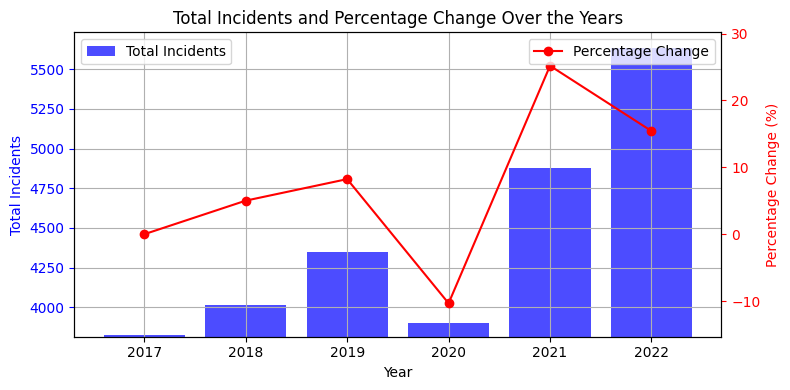

In [61]:
#VISUALIZATION
# the overall change in crime rates for the entire city

fig, ax1 = plt.subplots(figsize=(8, 4))
years= overall_crime_change["Year"]
total_incidents= overall_crime_change["Total_Incidents"]
percentage_change= overall_crime_change['Percentage_Change']

# Create bar graph for Total Incidents
bars= ax1.bar(years, total_incidents, color='b', alpha=0.7, label='Total Incidents')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Incidents', color='b')
ax1.tick_params('y', colors='b')

# Create line graph for Percentage Change
ax2 = ax1.twinx()
ax2.plot(years, percentage_change, marker='o', linestyle='-', color='r', label='Percentage Change')
ax2.set_ylabel('Percentage Change (%)', color='r')
ax2.tick_params('y', colors='r')

# Set different scales for the two y-axes
ax1.set_ylim(min(total_incidents) - 10, max(total_incidents) + 100)  # Set scale for Total Incidents
ax2.set_ylim(min(percentage_change) - 5, max(percentage_change) + 5)

# Add grid and legends
ax1.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
# Set title
plt.title('Total Incidents and Percentage Change Over the Years')

# Show plot
plt.tight_layout()
plt.show()

In [62]:
# Pivot the data to get total incidents for each year and neighborhood
neighborhood_yearly_crime = df.pivot_table(index='Neighborhood', columns='Year', values='Total_Incidents', aggfunc='sum').fillna(0)
# neighborhood_yearly_crime = neighborhood_yearly_crime.reset_index()
# neighborhood_yearly_crime.index.name = ""
neighborhood_yearly_crime['Crime_change'] = neighborhood_yearly_crime[2022] - neighborhood_yearly_crime[2017]
neighborhood_yearly_crime['Crime_rate_change'] = (((neighborhood_yearly_crime[2022] - neighborhood_yearly_crime[2017])/neighborhood_yearly_crime[2017])*100).fillna(0)
# neighborhood_yearly_crime.head(3)
# # neighborhood_yearly_crime.columns

In [63]:
# top 5 neighborhoods that have the highest increase of VIOLENT CRIMES
top5= neighborhood_yearly_crime.sort_values('Crime_change', ascending=False).head(5)
top5

Year,2017,2018,2019,2020,2021,2022,Crime_change,Crime_rate_change
Neighborhood,,,,,,,,
FRANKFORD,57.0,88.0,108.0,110.0,117.0,174.0,117.0,205.263158
DOWNTOWN,91.0,136.0,118.0,103.0,147.0,169.0,78.0,85.714286
UPTON,76.0,76.0,98.0,74.0,109.0,154.0,78.0,102.631579
MORRELL PARK,32.0,25.0,36.0,35.0,46.0,85.0,53.0,165.625000
BELAIR-EDISON,102.0,86.0,105.0,95.0,108.0,145.0,43.0,42.156863


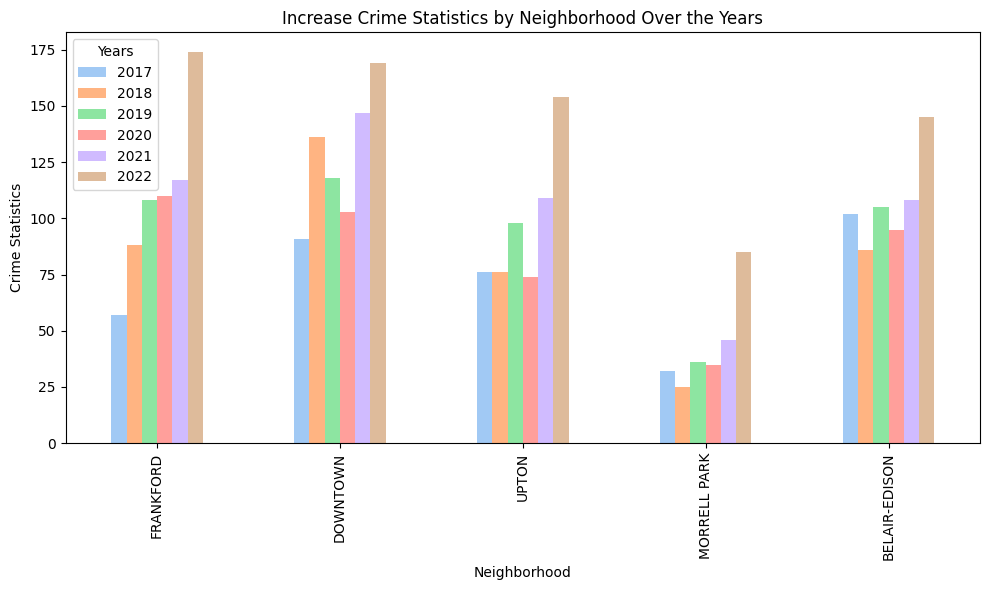

In [64]:
#visualise neighborhood with increase in crime
top5_df= top5.drop(columns=(["Crime_change","Crime_rate_change"]))

# Plotting
# Lighter shades of colors
colors = sns.color_palette("pastel", n_colors=len(top5_df.columns))
fig, ax = plt.subplots(figsize=(10, 6))
top5_df.plot(kind='bar',ax=ax,color= colors)
plt.xlabel('Neighborhood')
plt.ylabel('Crime Statistics')
plt.title('Increase Crime Statistics by Neighborhood Over the Years')
plt.legend(title='Years')
plt.tight_layout()
plt.show()


In [65]:
# top 5 neighborhoods that have the greatest decrease of VIOLENT CRIMES
least5=neighborhood_yearly_crime.sort_values('Crime_change', ascending=True).head(5)
least5

Year,2017,2018,2019,2020,2021,2022,Crime_change,Crime_rate_change
Neighborhood,,,,,,,,
PERKINS HOMES,16.0,13.0,15.0,13.0,3.0,1.0,-15.0,-93.750000
BOYD-BOOTH,24.0,6.0,15.0,14.0,12.0,13.0,-11.0,-45.833333
JOHNSTON SQUARE,39.0,28.0,30.0,19.0,23.0,29.0,-10.0,-25.641026
HOMELAND,13.0,10.0,9.0,0.0,2.0,4.0,-9.0,-69.230769
GREENMOUNT WEST,14.0,12.0,12.0,10.0,16.0,5.0,-9.0,-64.285714


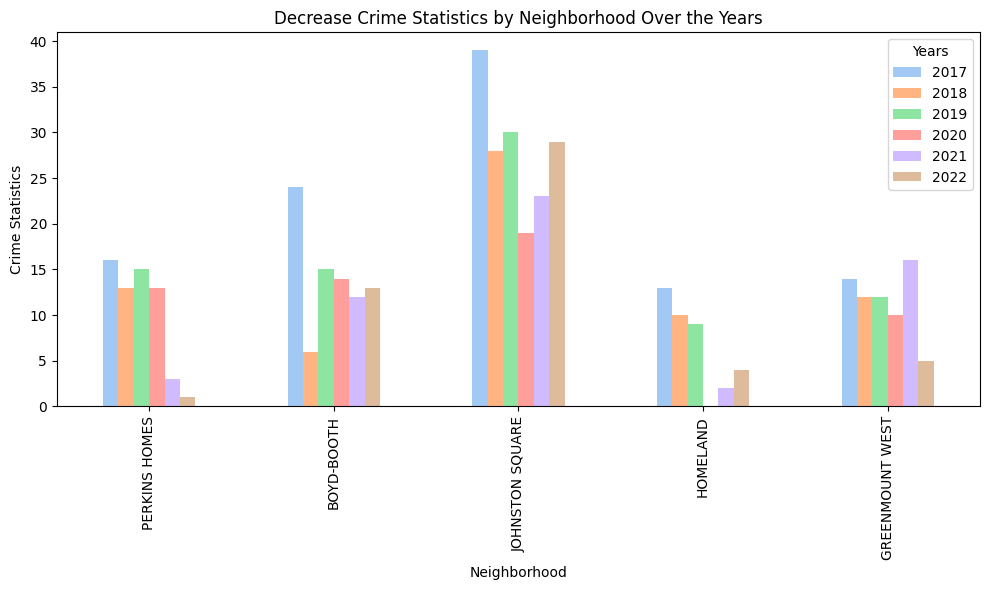

In [66]:

#visualise neighborhood with decrease in crime
least5_df= least5.drop(columns=(["Crime_change","Crime_rate_change"]))

# Plotting
# Lighter shades of colors
colors = sns.color_palette("pastel", n_colors=len(least5_df.columns))
fig, ax = plt.subplots(figsize=(10, 6))
least5_df.plot(kind='bar',ax=ax,color= colors)
plt.xlabel('Neighborhood')
plt.ylabel('Crime Statistics')
plt.title('Decrease Crime Statistics by Neighborhood Over the Years')
plt.legend(title='Years')
plt.tight_layout()
plt.show()

# PROJECT 2

## Read the 3 files


1.   Gun data
2.   Arrest data
3.   Rehab data




In [67]:
arrest_data=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data 601/Final Project/BPD_Arrests.csv")
gun_data= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data 601/Final Project/Gun_Offenders_Registry.csv")
rehab_data= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data 601/Final Project/Vacant_Building_Rehabs.csv")

In [68]:
#Data Preprocessing for Rehab data
rehab_data['Date'] = pd.to_datetime(rehab_data['DateIssue'], errors='coerce')
rehab_data = rehab_data[(rehab_data['Date'].dt.year >=2017) & (rehab_data['Date'].dt.year <=2022)]
rehab_data["Year"]= rehab_data["Date"].dt.year
df_rehab= rehab_data[["Year","Neighborhood"]]
df_rehab['Neighborhood'] = df_rehab['Neighborhood'].str.upper()
df_rehab['Neighborhood'] = df_rehab['Neighborhood'].str.strip()
df_rehab.dropna(inplace=True)

#Data Preprocessing for arrest data
arrest_data['Date'] = pd.to_datetime(arrest_data['ArrestDateTime'], errors='coerce')
arrest_data = arrest_data[(arrest_data['Date'].dt.year >=2017) & (arrest_data['Date'].dt.year <=2022)]
arrest_data["Year"]= arrest_data["Date"].dt.year
df_arrest= arrest_data[["Year","Neighborhood"]]
df_arrest['Neighborhood'] = df_arrest['Neighborhood'].str.upper()
df_arrest.dropna(inplace=True)

#Data Preprocessing for gun data
gun_data['Date'] = pd.to_datetime(gun_data['CreatedDate'], errors='coerce')
gun_data = gun_data[(gun_data['Date'].dt.year >=2017) & (gun_data['Date'].dt.year <=2022)]
gun_data["Year"]= gun_data["Date"].dt.year
df_gun= gun_data[["Year","Neighborhood"]]
df_gun['Neighborhood'] = df_gun['Neighborhood'].str.upper()
df_gun.dropna(inplace=True)

## Creating a list of the neighborhoods

In [69]:
#storing the result neighborhoods in a list
neigh_top5= top5.index.tolist()
neigh_least5= least5.index.tolist()

In [70]:
#creating a count dataframe for crime, gun, arrest

crime_count=df.groupby(['Neighborhood','Year'])['Total_Incidents'].sum().reset_index(name='crime_count')
crime_count['Identifier'] = crime_count['Neighborhood'] + '_' + crime_count['Year'].astype(str)
desired_order = ['Identifier', 'Neighborhood', 'Year','crime_count']
crime_count = crime_count[desired_order]


rehab_count = df_rehab.groupby(['Neighborhood','Year']).size().reset_index(name='rehab_count')
rehab_count['Identifier'] = rehab_count['Neighborhood'] + '_' + rehab_count['Year'].astype(str)
desired_order = ['Identifier', 'Neighborhood', 'Year','rehab_count' ]
rehab_count = rehab_count[desired_order]

arrest_count = df_arrest.groupby(['Neighborhood','Year']).size().reset_index(name='arrest_count')
arrest_count['Identifier'] = arrest_count['Neighborhood'] + '_' + arrest_count['Year'].astype(str)
desired_order = ['Identifier', 'Neighborhood', 'Year','arrest_count' ]
arrest_count = arrest_count[desired_order]


gun_count = df_gun.groupby(['Neighborhood','Year']).size().reset_index(name='gun_count')
gun_count['Identifier'] = gun_count['Neighborhood'] + '_' + gun_count['Year'].astype(str)
desired_order = ['Identifier', 'Neighborhood', 'Year','gun_count' ]
gun_count = gun_count[desired_order]

## Corelation with REHAB COUNTS for the neighbourhoods with the INCREASE in crime



In [71]:
crime_count_top5= crime_count[crime_count["Neighborhood"].isin(neigh_top5)]
rehab_count_top5= rehab_count[rehab_count["Neighborhood"].isin(neigh_top5)]

#combining crime and gun for top 5
crime_rehab_top5 = pd.merge(crime_count_top5, rehab_count_top5, on='Identifier', how='outer')
crime_rehab_top5.dropna(inplace=True)
crime_rehab_top5.drop(columns=["Neighborhood_y", "Year_y"], inplace=True)
crime_rehab_top5

,Identifier,Neighborhood_x,Year_x,crime_count,rehab_count
0,BELAIR-EDISON_2017,BELAIR-EDISON,2017,102,43.0
1,BELAIR-EDISON_2018,BELAIR-EDISON,2018,86,44.0
2,BELAIR-EDISON_2019,BELAIR-EDISON,2019,105,46.0
3,BELAIR-EDISON_2020,BELAIR-EDISON,2020,95,26.0
4,BELAIR-EDISON_2021,BELAIR-EDISON,2021,108,34.0
5,BELAIR-EDISON_2022,BELAIR-EDISON,2022,145,30.0
6,DOWNTOWN_2017,DOWNTOWN,2017,91,3.0
7,DOWNTOWN_2018,DOWNTOWN,2018,136,1.0
8,DOWNTOWN_2019,DOWNTOWN,2019,118,6.0
9,DOWNTOWN_2020,DOWNTOWN,2020,103,3.0


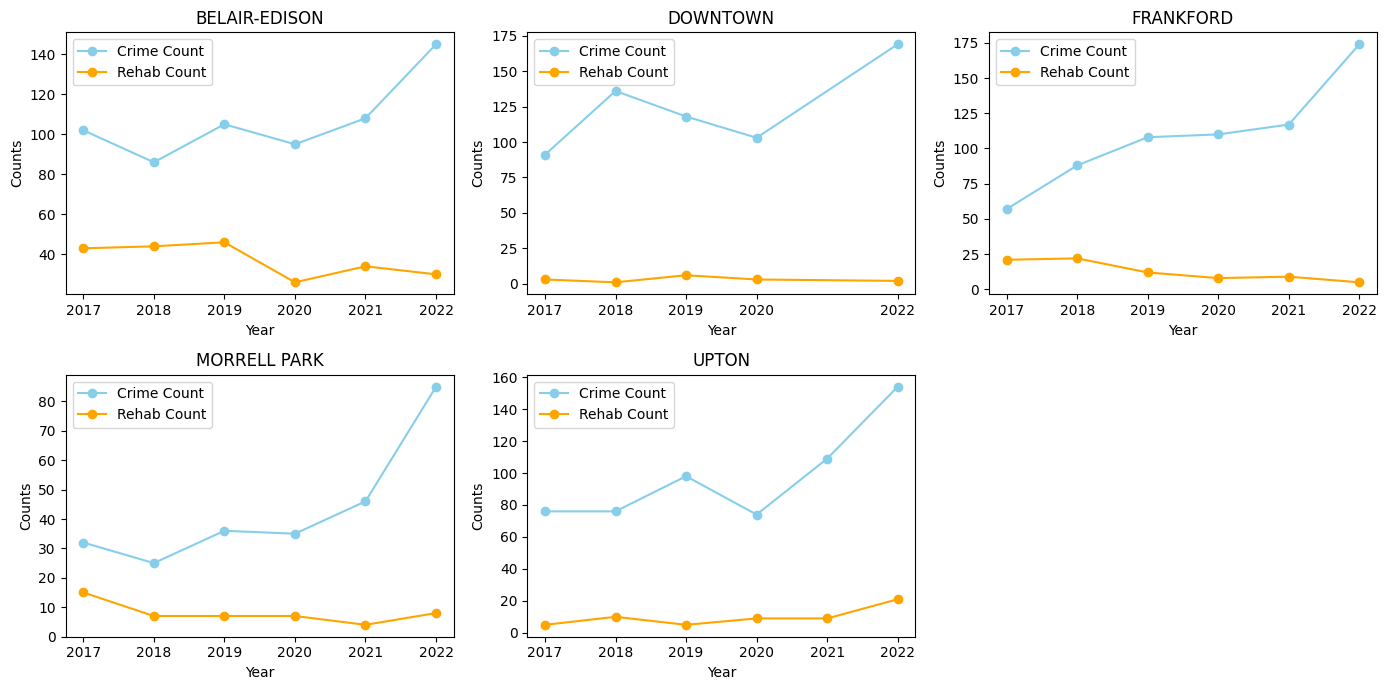

In [72]:
## VISUALISATION with line graph

neighborhoods = crime_rehab_top5['Neighborhood_x'].unique()

# Create subplots for each neighborhood in a 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(14, 7))
fig.subplots_adjust(hspace=0.5)

for i, neighborhood in enumerate(neighborhoods):
    sub_df = crime_rehab_top5[crime_rehab_top5['Neighborhood_x'] == neighborhood]
    row = i // 3
    col = i % 3

    axs[row, col].plot(sub_df['Year_x'], sub_df['crime_count'], marker='o', label='Crime Count', color='skyblue')
    axs[row, col].plot(sub_df['Year_x'], sub_df['rehab_count'], marker='o', label='Rehab Count', color='orange')
    axs[row, col].set_title(f'{neighborhood}')
    axs[row, col].set_xlabel('Year')
    axs[row, col].set_ylabel('Counts')
    axs[row, col].set_xticks(sub_df['Year_x'])
    axs[row, col].legend()
    # axs[row, col].legend(['Crime Count', 'Gun Count'])

# Hide empty subplot(s) if there are less than 6 neighborhoods
if len(neighborhoods) < 6:
    for i in range(len(neighborhoods), 6):
        row = i // 3
        col = i % 3
        fig.delaxes(axs[row, col])

plt.tight_layout()
plt.show()

In [73]:
#hypothesis testing

#Since we need to compare the numerical data across different neighborhoods and years
# a paired T-test would be more suitable for comparing means or differences between these variables within each neighborhood

from scipy.stats import ttest_rel
t_statistic, p_value = ttest_rel(crime_rehab_top5['crime_count'], crime_rehab_top5['rehab_count'])

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

alpha = 0.05  # Set your desired alpha level

if p_value < alpha:
    print("Reject Null Hypothesis: There is a significant difference between crime_count and rehab_count.")
else:
    print("Fail to Reject Null Hypothesis: There is no significant difference between crime_count and rehab_count.")


pearson_corr = crime_rehab_top5['crime_count'].corr(crime_rehab_top5['rehab_count'])

print(f"\nPearson's correlation coefficient: {pearson_corr}")

T-statistic: 10.72448959525234
P-value: 2.0101177091110666e-11
Reject Null Hypothesis: There is a significant difference between crime_count and rehab_count.

Pearson's correlation coefficient: 0.06043446371717581


In [74]:
# #chi square
# # Create a contingency table
# contingency_table = pd.crosstab(crime_rehab_top5['crime_count'], crime_rehab_top5['rehab_count'])
# # Perform Chi-square test
# chi2, p, dof, expected = chi2_contingency(contingency_table)
# print(f"\nChi-square value: {chi2}")
# print(f"P-value: {p}")

## Corelation with REHAB COUNTS for the neighbourhoods with the DECREASE in crime



In [75]:
crime_count_least5= crime_count[crime_count["Neighborhood"].isin(neigh_least5)]
rehab_count_least5= rehab_count[rehab_count["Neighborhood"].isin(neigh_least5)]

#combining crime and gun for top 5
crime_rehab_least5 = pd.merge(crime_count_least5, rehab_count_least5, on='Identifier', how='outer')
crime_rehab_least5.dropna(inplace=True)
crime_rehab_least5.drop(columns=["Neighborhood_y", "Year_y"], inplace=True)
crime_rehab_least5

,Identifier,Neighborhood_x,Year_x,crime_count,rehab_count
0,BOYD-BOOTH_2017,BOYD-BOOTH,2017,24,2.0
1,BOYD-BOOTH_2018,BOYD-BOOTH,2018,6,3.0
2,BOYD-BOOTH_2019,BOYD-BOOTH,2019,15,1.0
4,BOYD-BOOTH_2021,BOYD-BOOTH,2021,12,4.0
5,BOYD-BOOTH_2022,BOYD-BOOTH,2022,13,5.0
6,GREENMOUNT WEST_2017,GREENMOUNT WEST,2017,14,13.0
7,GREENMOUNT WEST_2018,GREENMOUNT WEST,2018,12,13.0
8,GREENMOUNT WEST_2019,GREENMOUNT WEST,2019,12,10.0
9,GREENMOUNT WEST_2020,GREENMOUNT WEST,2020,10,6.0
10,GREENMOUNT WEST_2021,GREENMOUNT WEST,2021,16,3.0


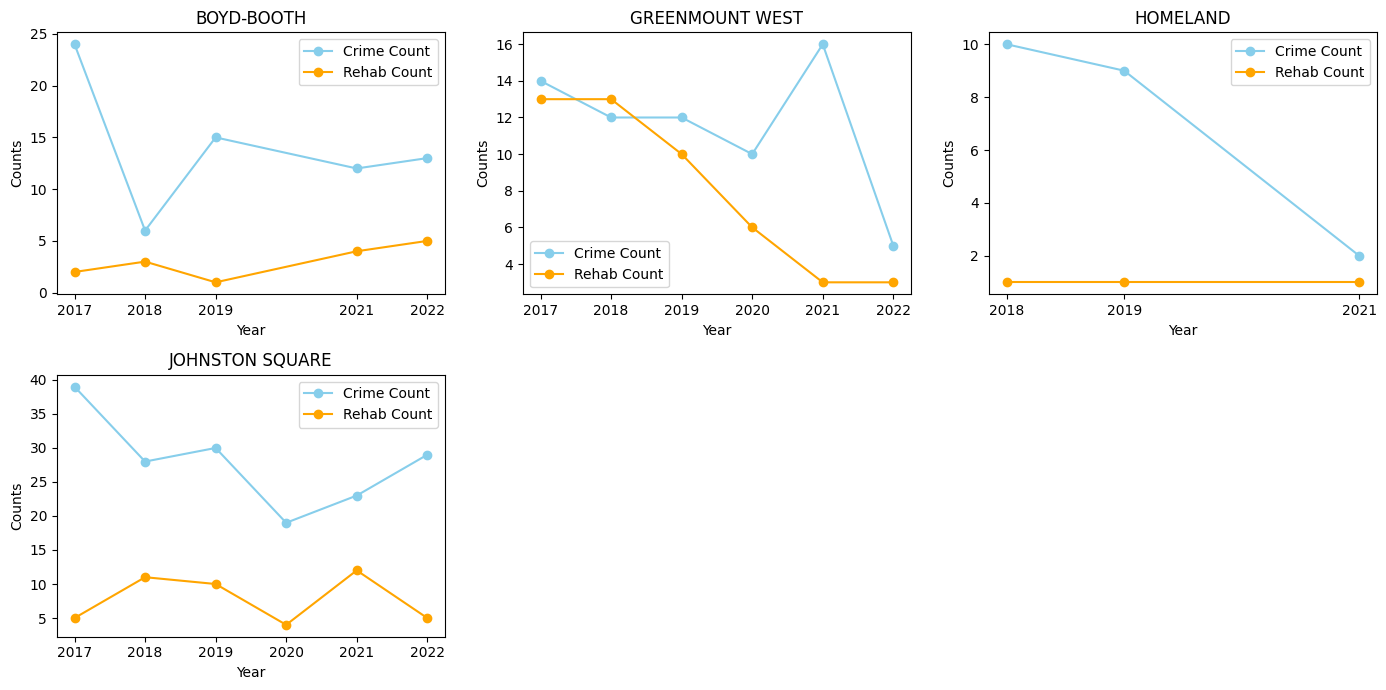

In [76]:
## VISUALISATION with line graph

neighborhoods = crime_rehab_least5['Neighborhood_x'].unique()

# Create subplots for each neighborhood in a 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(14, 7))
fig.subplots_adjust(hspace=0.5)

for i, neighborhood in enumerate(neighborhoods):
    sub_df = crime_rehab_least5[crime_rehab_least5['Neighborhood_x'] == neighborhood]
    row = i // 3
    col = i % 3

    axs[row, col].plot(sub_df['Year_x'], sub_df['crime_count'], marker='o', label='Crime Count', color='skyblue')
    axs[row, col].plot(sub_df['Year_x'], sub_df['rehab_count'], marker='o', label='Rehab Count', color='orange')
    axs[row, col].set_title(f'{neighborhood}')
    axs[row, col].set_xlabel('Year')
    axs[row, col].set_ylabel('Counts')
    axs[row, col].set_xticks(sub_df['Year_x'])
    axs[row, col].legend()
    # axs[row, col].legend(['Crime Count', 'Gun Count'])

# Hide empty subplot(s) if there are less than 6 neighborhoods
if len(neighborhoods) < 6:
    for i in range(len(neighborhoods), 6):
        row = i // 3
        col = i % 3
        fig.delaxes(axs[row, col])

plt.tight_layout()
plt.show()

In [77]:
from scipy.stats import ttest_rel
t_statistic, p_value = ttest_rel(crime_rehab_least5['crime_count'], crime_rehab_least5['rehab_count'])

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

alpha = 0.05  # Set your desired alpha level

if p_value < alpha:
    print("Reject Null Hypothesis: There is a significant difference between crime_count and rehab_count.")
else:
    print("Fail to Reject Null Hypothesis: There is no significant difference between crime_count and rehab_count.")


pearson_corr = crime_rehab_least5['crime_count'].corr(crime_rehab_least5['rehab_count'])

print(f"\nPearson's correlation coefficient: {pearson_corr}")

T-statistic: 5.21653511200186
P-value: 4.912781772276238e-05
Reject Null Hypothesis: There is a significant difference between crime_count and rehab_count.

Pearson's correlation coefficient: 0.31298644919160684


In [78]:
# #chi square
# # Create a contingency table
# contingency_table = pd.crosstab(crime_rehab_least5['crime_count'], crime_rehab_least5['rehab_count'])
# # Perform Chi-square test
# chi2, p, dof, expected = chi2_contingency(contingency_table)
# print(f"\nChi-square value: {chi2}")
# print(f"P-value: {p}")

## Corelation with ARREST COUNTS for the neighbourhoods with the INCREASE in crime



In [79]:
arrest_count_top5= arrest_count[arrest_count["Neighborhood"].isin(neigh_top5)]

#combining crime and gun for top 5
crime_arrest_top5 = pd.merge(crime_count_top5, arrest_count_top5, on='Identifier', how='outer')
crime_arrest_top5.dropna(inplace=True)
crime_arrest_top5.drop(columns=["Neighborhood_y", "Year_y"], inplace=True)
crime_arrest_top5

,Identifier,Neighborhood_x,Year_x,crime_count,arrest_count
0,BELAIR-EDISON_2017,BELAIR-EDISON,2017,102,278
1,BELAIR-EDISON_2018,BELAIR-EDISON,2018,86,289
2,BELAIR-EDISON_2019,BELAIR-EDISON,2019,105,224
3,BELAIR-EDISON_2020,BELAIR-EDISON,2020,95,129
4,BELAIR-EDISON_2021,BELAIR-EDISON,2021,108,96
5,BELAIR-EDISON_2022,BELAIR-EDISON,2022,145,61
6,DOWNTOWN_2017,DOWNTOWN,2017,91,363
7,DOWNTOWN_2018,DOWNTOWN,2018,136,331
8,DOWNTOWN_2019,DOWNTOWN,2019,118,452
9,DOWNTOWN_2020,DOWNTOWN,2020,103,253


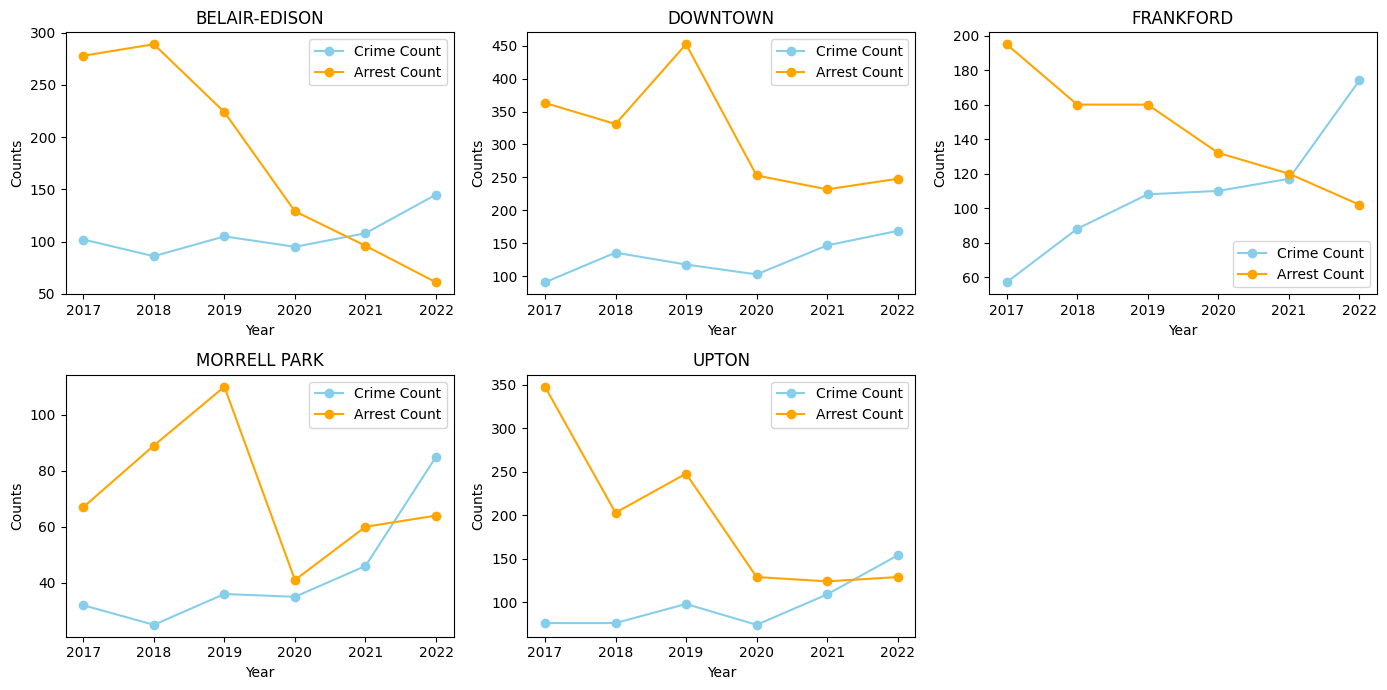

In [80]:
##line graph

neighborhoods = crime_arrest_top5['Neighborhood_x'].unique()

# Create subplots for each neighborhood in a 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(14, 7))
fig.subplots_adjust(hspace=0.5)

for i, neighborhood in enumerate(neighborhoods):
    sub_df = crime_arrest_top5[crime_arrest_top5['Neighborhood_x'] == neighborhood]
    row = i // 3
    col = i % 3

    axs[row, col].plot(sub_df['Year_x'], sub_df['crime_count'], marker='o', label='Crime Count', color='skyblue')
    axs[row, col].plot(sub_df['Year_x'], sub_df['arrest_count'], marker='o', label='Arrest Count', color='orange')
    axs[row, col].set_title(f'{neighborhood}')
    axs[row, col].set_xlabel('Year')
    axs[row, col].set_ylabel('Counts')
    axs[row, col].set_xticks(sub_df['Year_x'])
    axs[row, col].legend()
    # axs[row, col].legend(['Crime Count', 'Gun Count'])

# Hide empty subplot(s) if there are less than 6 neighborhoods
if len(neighborhoods) < 6:
    for i in range(len(neighborhoods), 6):
        row = i // 3
        col = i % 3
        fig.delaxes(axs[row, col])

plt.tight_layout()
plt.show()

In [81]:
from scipy.stats import ttest_rel
t_statistic, p_value = ttest_rel(crime_arrest_top5['crime_count'], crime_arrest_top5['arrest_count'])

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

alpha = 0.05  # Set your desired alpha level

if p_value < alpha:
    print("Reject Null Hypothesis: There is a significant difference between crime_count and arrest_count.")
else:
    print("Fail to Reject Null Hypothesis: There is no significant difference between crime_count and arrest_count.")


pearson_corr = crime_arrest_top5['crime_count'].corr(crime_arrest_top5['arrest_count'])

print(f"\nPearson's correlation coefficient: {pearson_corr}")

T-statistic: -4.536775324129274
P-value: 9.17193551592652e-05
Reject Null Hypothesis: There is a significant difference between crime_count and arrest_count.

Pearson's correlation coefficient: 0.25888728672647443


In [82]:
# #chi square

# # Create a contingency table
# contingency_table = pd.crosstab(crime_arrest_top5['crime_count'], crime_arrest_top5['arrest_count'])

# # Perform Chi-square test
# chi2, p, dof, expected = chi2_contingency(contingency_table)
# print(f"Chi-square value: {chi2}")
# print(f"P-value: {p}")

## Corelation with ARREST COUNTS for the neighbourhoods with the DECREASE in crime



In [83]:
crime_count_least5= crime_count[crime_count["Neighborhood"].isin(neigh_least5)]
arrest_count_least5= arrest_count[arrest_count["Neighborhood"].isin(neigh_least5)]

#combining crime and gun for top 5
crime_arrest_least5 = pd.merge(crime_count_least5, arrest_count_least5, on='Identifier', how='outer')
crime_arrest_least5.dropna(inplace=True)
crime_arrest_least5.drop(columns=["Neighborhood_y", "Year_y"], inplace=True)
crime_arrest_least5

,Identifier,Neighborhood_x,Year_x,crime_count,arrest_count
0,BOYD-BOOTH_2017,BOYD-BOOTH,2017.0,24.0,122
1,BOYD-BOOTH_2018,BOYD-BOOTH,2018.0,6.0,53
2,BOYD-BOOTH_2019,BOYD-BOOTH,2019.0,15.0,46
3,BOYD-BOOTH_2020,BOYD-BOOTH,2020.0,14.0,18
4,BOYD-BOOTH_2021,BOYD-BOOTH,2021.0,12.0,9
5,BOYD-BOOTH_2022,BOYD-BOOTH,2022.0,13.0,20
6,GREENMOUNT WEST_2017,GREENMOUNT WEST,2017.0,14.0,30
7,GREENMOUNT WEST_2018,GREENMOUNT WEST,2018.0,12.0,13
8,GREENMOUNT WEST_2019,GREENMOUNT WEST,2019.0,12.0,10
9,GREENMOUNT WEST_2020,GREENMOUNT WEST,2020.0,10.0,9


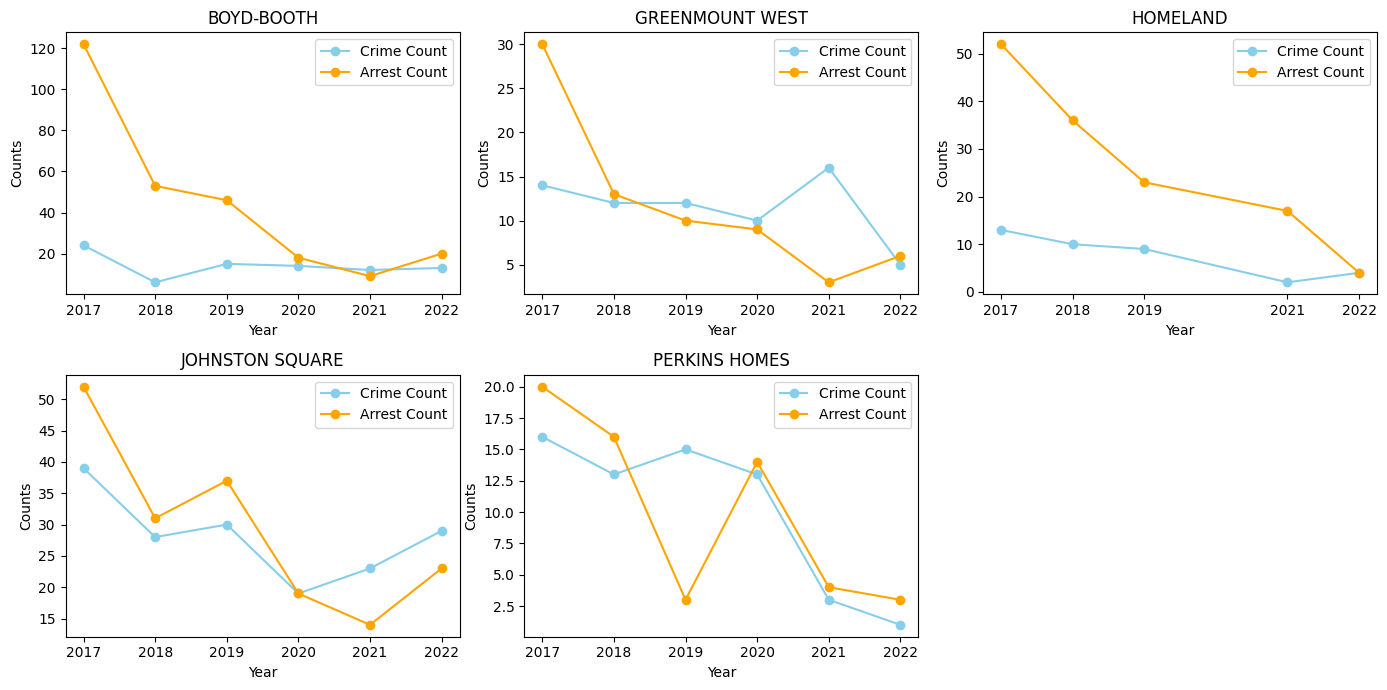

In [84]:
##line graph

neighborhoods = crime_arrest_least5['Neighborhood_x'].unique()

# Create subplots for each neighborhood in a 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(14, 7))
fig.subplots_adjust(hspace=0.5)

for i, neighborhood in enumerate(neighborhoods):
    sub_df = crime_arrest_least5[crime_arrest_least5['Neighborhood_x'] == neighborhood]
    row = i // 3
    col = i % 3

    axs[row, col].plot(sub_df['Year_x'], sub_df['crime_count'], marker='o', label='Crime Count', color='skyblue')
    axs[row, col].plot(sub_df['Year_x'], sub_df['arrest_count'], marker='o', label='Arrest Count', color='orange')
    axs[row, col].set_title(f'{neighborhood}')
    axs[row, col].set_xlabel('Year')
    axs[row, col].set_ylabel('Counts')
    axs[row, col].set_xticks(sub_df['Year_x'])
    axs[row, col].legend()
    # axs[row, col].legend(['Crime Count', 'Gun Count'])

# Hide empty subplot(s) if there are less than 6 neighborhoods
if len(neighborhoods) < 6:
    for i in range(len(neighborhoods), 6):
        row = i // 3
        col = i % 3
        fig.delaxes(axs[row, col])

plt.tight_layout()
plt.show()

In [85]:
from scipy.stats import ttest_rel
t_statistic, p_value = ttest_rel(crime_arrest_least5['crime_count'], crime_arrest_least5['arrest_count'])

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

alpha = 0.05  # Set your desired alpha level

if p_value < alpha:
    print("Reject Null Hypothesis: There is a significant difference between crime_count and arrest_count.")
else:
    print("Fail to Reject Null Hypothesis: There is no significant difference between crime_count and arrest_count.")


pearson_corr = crime_arrest_least5['crime_count'].corr(crime_arrest_least5['arrest_count'])

print(f"\nPearson's correlation coefficient: {pearson_corr}")

T-statistic: -2.420276411440015
P-value: 0.022247189301684227
Reject Null Hypothesis: There is a significant difference between crime_count and arrest_count.

Pearson's correlation coefficient: 0.42525100182998576


## Corelation with GUN COUNTS for the neighbourhoods with the INCREASE in crime

---



In [86]:
crime_count_top5= crime_count[crime_count["Neighborhood"].isin(neigh_top5)]
gun_count_top5= gun_count[gun_count["Neighborhood"].isin(neigh_top5)]

#combining crime and gun for top 5
crime_gun_top5 = pd.merge(crime_count_top5, gun_count_top5, on='Identifier', how='outer')
crime_gun_top5.dropna(inplace=True)
crime_gun_top5.drop(columns=["Neighborhood_y", "Year_y"], inplace=True)
crime_gun_top5

,Identifier,Neighborhood_x,Year_x,crime_count,gun_count
0,BELAIR-EDISON_2017,BELAIR-EDISON,2017,102,6.0
1,BELAIR-EDISON_2018,BELAIR-EDISON,2018,86,8.0
2,BELAIR-EDISON_2019,BELAIR-EDISON,2019,105,13.0
3,BELAIR-EDISON_2020,BELAIR-EDISON,2020,95,15.0
4,BELAIR-EDISON_2021,BELAIR-EDISON,2021,108,30.0
5,BELAIR-EDISON_2022,BELAIR-EDISON,2022,145,44.0
9,DOWNTOWN_2020,DOWNTOWN,2020,103,1.0
10,DOWNTOWN_2021,DOWNTOWN,2021,147,1.0
12,FRANKFORD_2017,FRANKFORD,2017,57,4.0
13,FRANKFORD_2018,FRANKFORD,2018,88,6.0


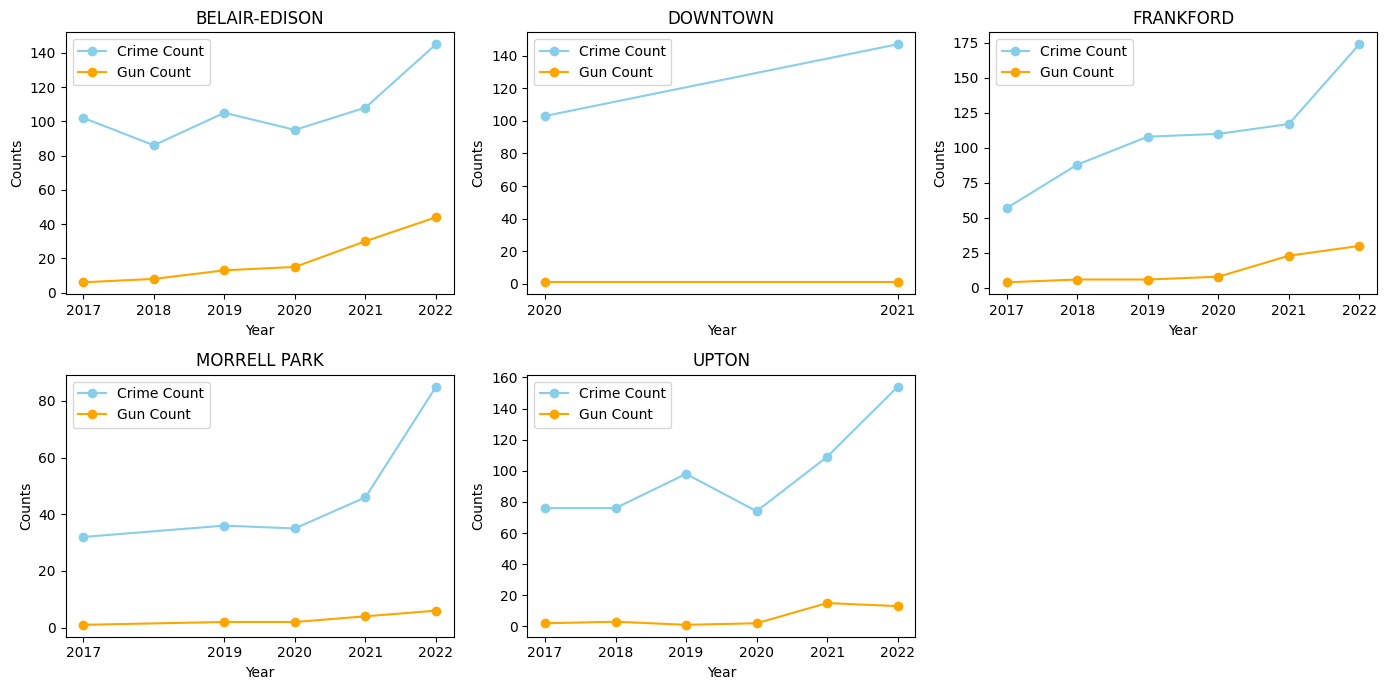

In [87]:
##line graph

neighborhoods = crime_gun_top5['Neighborhood_x'].unique()

# Create subplots for each neighborhood in a 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(14, 7))
fig.subplots_adjust(hspace=0.5)

for i, neighborhood in enumerate(neighborhoods):
    sub_df = crime_gun_top5[crime_gun_top5['Neighborhood_x'] == neighborhood]
    row = i // 3
    col = i % 3

    axs[row, col].plot(sub_df['Year_x'], sub_df['crime_count'], marker='o', label='Crime Count', color='skyblue')
    axs[row, col].plot(sub_df['Year_x'], sub_df['gun_count'], marker='o', label='Gun Count', color='orange')
    axs[row, col].set_title(f'{neighborhood}')
    axs[row, col].set_xlabel('Year')
    axs[row, col].set_ylabel('Counts')
    axs[row, col].set_xticks(sub_df['Year_x'])
    axs[row, col].legend()
    # axs[row, col].legend(['Crime Count', 'Gun Count'])

# Hide empty subplot(s) if there are less than 6 neighborhoods
if len(neighborhoods) < 6:
    for i in range(len(neighborhoods), 6):
        row = i // 3
        col = i % 3
        fig.delaxes(axs[row, col])

plt.tight_layout()
plt.show()

In [88]:
from scipy.stats import ttest_rel
t_statistic, p_value = ttest_rel(crime_gun_top5['crime_count'], crime_gun_top5['gun_count'])

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

alpha = 0.05  # Set your desired alpha level

if p_value < alpha:
    print("Reject Null Hypothesis: There is a significant difference between crime_count and gun_count.")
else:
    print("Fail to Reject Null Hypothesis: There is no significant difference between crime_count and gun_count.")


pearson_corr = crime_gun_top5['crime_count'].corr(crime_gun_top5['gun_count'])

print(f"\nPearson's correlation coefficient: {pearson_corr}")

T-statistic: 13.512049839304584
P-value: 1.031688286888082e-12
Reject Null Hypothesis: There is a significant difference between crime_count and gun_count.

Pearson's correlation coefficient: 0.6099997085909663


## Corelation with GUN COUNTS for the neighbourhoods with the DECREASE in crime

In [89]:
crime_count_least5= crime_count[crime_count["Neighborhood"].isin(neigh_least5)]
gun_count_least5= gun_count[gun_count["Neighborhood"].isin(neigh_least5)]

#combining crime and gun for top 5
crime_gun_least5 = pd.merge(crime_count_least5, gun_count_least5, on='Identifier', how='outer')
crime_gun_least5.dropna(inplace=True)
crime_gun_least5.drop(columns=["Neighborhood_y", "Year_y"], inplace=True)
crime_gun_least5

,Identifier,Neighborhood_x,Year_x,crime_count,gun_count
3,BOYD-BOOTH_2020,BOYD-BOOTH,2020,14,1.0
4,BOYD-BOOTH_2021,BOYD-BOOTH,2021,12,2.0
5,BOYD-BOOTH_2022,BOYD-BOOTH,2022,13,5.0
6,GREENMOUNT WEST_2017,GREENMOUNT WEST,2017,14,2.0
8,GREENMOUNT WEST_2019,GREENMOUNT WEST,2019,12,1.0
10,GREENMOUNT WEST_2021,GREENMOUNT WEST,2021,16,1.0
11,GREENMOUNT WEST_2022,GREENMOUNT WEST,2022,5,1.0
14,HOMELAND_2019,HOMELAND,2019,9,1.0
15,HOMELAND_2021,HOMELAND,2021,2,1.0
16,HOMELAND_2022,HOMELAND,2022,4,1.0


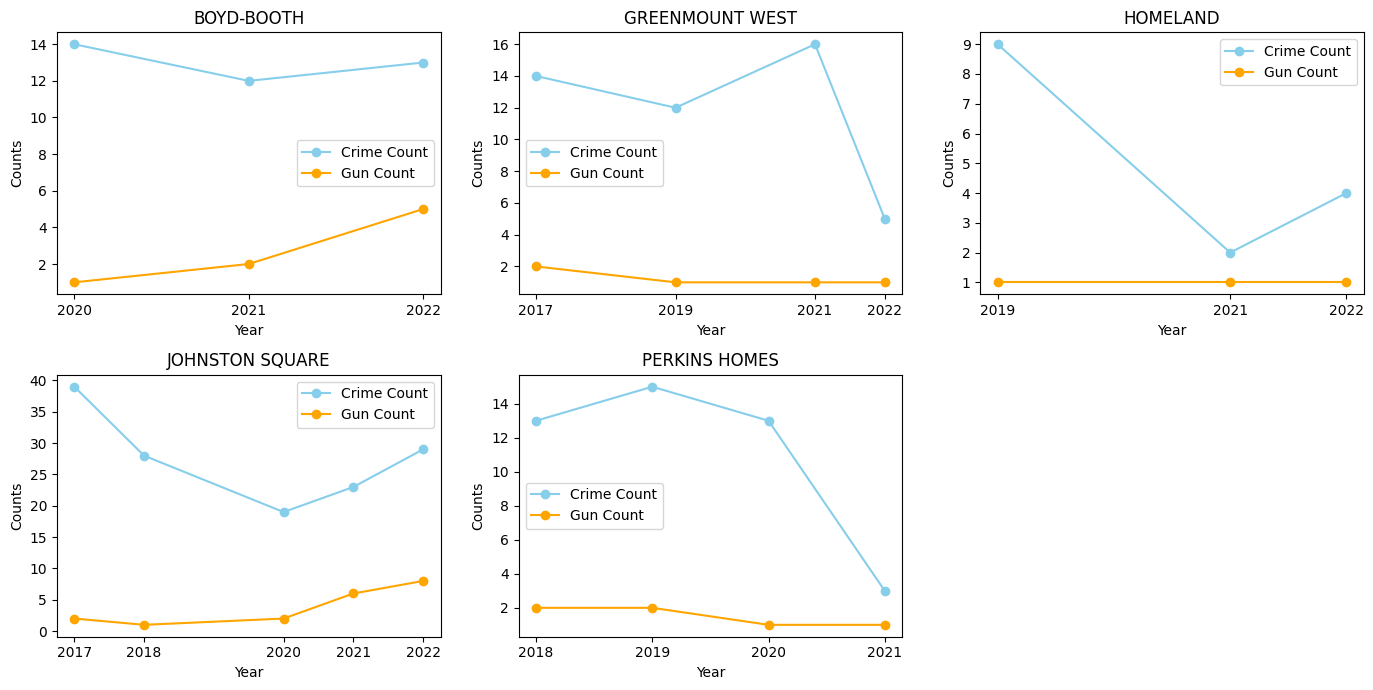

In [90]:
##line graph

neighborhoods = crime_gun_least5['Neighborhood_x'].unique()

# Create subplots for each neighborhood in a 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(14, 7))
fig.subplots_adjust(hspace=0.5)

for i, neighborhood in enumerate(neighborhoods):
    sub_df = crime_gun_least5[crime_gun_least5['Neighborhood_x'] == neighborhood]
    row = i // 3
    col = i % 3

    axs[row, col].plot(sub_df['Year_x'], sub_df['crime_count'], marker='o', label='Crime Count', color='skyblue')
    axs[row, col].plot(sub_df['Year_x'], sub_df['gun_count'], marker='o', label='Gun Count', color='orange')
    axs[row, col].set_title(f'{neighborhood}')
    axs[row, col].set_xlabel('Year')
    axs[row, col].set_ylabel('Counts')
    axs[row, col].set_xticks(sub_df['Year_x'])
    axs[row, col].legend()
    # axs[row, col].legend(['Crime Count', 'Gun Count'])

# Hide empty subplot(s) if there are less than 6 neighborhoods
if len(neighborhoods) < 6:
    for i in range(len(neighborhoods), 6):
        row = i // 3
        col = i % 3
        fig.delaxes(axs[row, col])

plt.tight_layout()
plt.show()

In [91]:
from scipy.stats import ttest_rel
t_statistic, p_value = ttest_rel(crime_gun_least5['crime_count'], crime_gun_least5['gun_count'])

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

alpha = 0.05  # Set your desired alpha level

if p_value < alpha:
    print("Reject Null Hypothesis: There is a significant difference between crime_count and gun_count.")
else:
    print("Fail to Reject Null Hypothesis: There is no significant difference between crime_count and gun_count.")


pearson_corr = crime_gun_least5['crime_count'].corr(crime_gun_least5['gun_count'])

print(f"\nPearson's correlation coefficient: {pearson_corr}")

T-statistic: 6.327653420677774
P-value: 5.801497690843811e-06
Reject Null Hypothesis: There is a significant difference between crime_count and gun_count.

Pearson's correlation coefficient: 0.45600531583952514


In [92]:
# from scipy.stats import chi2_contingency

# # Create a contingency table
# contingency_table = pd.crosstab(crime_gun_least5['crime_count'], crime_gun_least5['gun_count'])

# # Perform Chi-square test
# chi2, p, dof, expected = chi2_contingency(contingency_table)
# print(f"Chi-square value: {chi2}")
# print(f"P-value: {p}")